In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from numba import njit
from tqdm.notebook import tqdm
import talib
import pickle
import pystan

import os, sys

sys.path.append(os.path.abspath(os.path.join('../')))
from generative_models import *
from fast_dm_simulator import *

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

In [2]:
%load_ext autoreload
%autoreload 2
np.set_printoptions(suppress=True)

In [3]:
# set font type
import matplotlib
matplotlib.rcParams['font.serif'] = "Palatino"
matplotlib.rcParams['font.family'] = "serif"

## Network architecture

In [4]:
class HeteroscedasticNetwork(tf.keras.Model):
    
    def __init__(self, n_params_d, n_params_s):
        super(HeteroscedasticNetwork, self).__init__()
        
        self.preprocessor = Sequential([
            GRU(64, return_sequences=True),
            LSTM(128, return_sequences=True),
            Dense(128, activation='selu', kernel_initializer='lecun_normal'),
        ])
        
        self.dynamic_predictor = Sequential([
            Dense(64, activation='selu', kernel_initializer='lecun_normal'),
            tf.keras.layers.Dense(tfpl.MultivariateNormalTriL.params_size(n_params_d)),
            tfpl.MultivariateNormalTriL(n_params_d)
        ])

        self.static_predictor = Sequential([
            LSTM(n_params_s),
            Dense(tfpl.MultivariateNormalTriL.params_size(n_params_s)),
            tfpl.MultivariateNormalTriL(n_params_s)
        ])
        
    def call(self, x):
        """
        Forward pass through the model.
        """
        
        # Obtain representation
        rep = self.preprocessor(x)
        
        # Predict dynamic
        preds_dyn = self.dynamic_predictor(rep)

        # predict static
        preds_stat = self.static_predictor(rep)

        return preds_dyn, preds_stat

## Load trained network

In [5]:
# initialize net
network = HeteroscedasticNetwork(6, 6)
network.load_weights('checkpoints/varying_hyperparams_3200')

## Read data

In [6]:
# read empirical data
data = pd.read_csv('../../data/data_lexical_decision.csv', sep=',', header=0)
data.rt[data.rt < 0.2] = np.nan

/var/folders/cd/lsff0c7s4fn3mb649wt67m200000gn/T/ipykernel_4901/116837441.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rt[data.rt < 0.2] = np.nan


In [ ]:
# x = np.array([1, 2, np.nan, 4, 5])
# index = np.where(np.isnan(x))[0][0]
# x[0:index]
# new = np.concatenate((x[0:index], [3], x[index+1:]))
# new

In [11]:
# read fast-dm parameters
fast_dm_params = pd.read_csv('errorcoding_ddm_ks.lst', encoding='iso-8859-1', header=0, delim_whitespace=True)
fast_dm_params['dataset'] = fast_dm_params['dataset'].str.extract('(\d+)').astype(int)
fast_dm_params = fast_dm_params[['dataset', 'v_1', 'v_2', 'v_3', 'v_4', 'a', 't0', 'sv', 'st0']]
fast_dm_params = fast_dm_params.sort_values('dataset')
fast_dm_params = fast_dm_params.reset_index(drop=True)
fast_dm_params.shape

(11, 9)

## Prediction

In [12]:
def pr_check(emp_data, post_d_samples, n_sim, sma_period=5):
    # get experimental context
    context = emp_data.stim_type.values - 1
    # get empirical response times
    emp_rt = np.abs(emp_data.rt.values)
    sma_emp_rt = talib.SMA(emp_rt, timeperiod=sma_period)

    n_obs = emp_rt.shape[0]
    pred_rt = np.zeros((n_sim, n_obs))
    sma_pred_rt = np.zeros((n_sim, n_obs))
    # iterate over number of simulations
    for sim in range(n_sim):
        # Iterate over number of trials
        rt = np.zeros(n_obs)
        for t in range(n_obs):
            # Run diffusion process
            rt[t] = diffusion_trial(post_d_samples[sim, t, context[t]], post_d_samples[sim, t, 4], post_d_samples[sim, t, 5])
        pred_rt[sim] = np.abs(rt)
        sma_pred_rt[sim] = talib.SMA(np.abs(rt), timeperiod=sma_period)

    return pred_rt, sma_pred_rt

In [20]:
post_samples = np.array(post_d.mean())
post_samples.shape

(1, 3200, 6)

In [21]:
n_sim = 1
np.array([post_d.sample(n_sim)])[0, :, 0, :].shape

(1, 3200, 6)

In [18]:
post_d.mean()

<tf.Tensor: shape=(1, 3200, 6), dtype=float32, numpy=
array([[[1.8857307 , 1.7575734 , 1.8291779 , 1.8421686 , 1.5955784 ,
         0.4370365 ],
        [1.8495615 , 1.6494703 , 1.496359  , 1.6513608 , 1.595593  ,
         0.4203326 ],
        [1.7494004 , 1.6696901 , 1.5780379 , 1.9139278 , 1.524899  ,
         0.42500234],
        ...,
        [4.740368  , 2.7453604 , 2.400854  , 3.7902596 , 1.3727686 ,
         0.3940056 ],
        [4.781581  , 2.7852733 , 2.4062505 , 3.812236  , 1.3682208 ,
         0.3938988 ],
        [4.7764435 , 2.7702014 , 2.436299  , 3.788992  , 1.3558633 ,
         0.39441288]]], dtype=float32)>

In [22]:
n_sub = fast_dm_params.shape[0]
n_sim = 1

# initialize data structure
pred_data_dynamic = np.empty((n_sub, n_sim, 3200))
pred_data_sma = np.empty((n_sub, n_sim, 3200))
pred_data_fast_dm = np.empty((n_sub, 3200))
emp_data = np.empty((n_sub, 3200))
emp_data_sma = np.empty((n_sub, 3200))

for sub in np.unique(data.id):
    # subset empirical data
    person_data = data[data.id == sub]

    # check for nan in rt data
    if person_data.rt.isnull().any():
        rt_nan_index = np.where(np.isnan(person_data.rt))[0][0]
        fitting_data = person_data.dropna()
    else:
        fitting_data = person_data.copy()

    # prepare for amortized inference
    fitting_data.rt[fitting_data.acc == 0] = -fitting_data.rt[fitting_data.acc == 0]
    rt = np.array([fitting_data.rt])[:, :, np.newaxis]
    stim_type = np.array([fitting_data.stim_type])[:, :, np.newaxis] - 1 
    context = to_categorical(stim_type)
    x_nn = tf.concat((rt, context), axis=-1)

    # amortized inference
    post_d, post_s = network(x_nn)

    # sample from posterior
    if person_data.rt.isnull().any():
        # post_samples = np.array([post_d.sample(n_sim)])[0, :, 0, :]
        post_samples = np.array(post_d.mean())
        lost_post = post_samples[:, rt_nan_index]
        lost_post = lost_post[:, np.newaxis, :]
        post_samples = np.concatenate((post_samples[:, 0:rt_nan_index], lost_post,
                                       post_samples[:, rt_nan_index:]),axis=1)
    else:
        # post_samples = np.array([post_d.sample(n_sim)])[0, :, 0, :]
        post_samples = np.array(post_d.mean())
        
    # get fast-dm parameter estimates
    person_fast_dm_params = fast_dm_params[fast_dm_params.dataset == sub].values[0, 1:]

    # predction dynamic
    pred_rt_dynamic, sma_pred_rt_dynamic = pr_check(person_data, post_samples, n_sim)

    # prediction fast-dm
    context = np.array(person_data['stim_type'] - 1)
    pred_rt_fast_dm = fast_dm_simulate(person_fast_dm_params, context)

    emp_rt = np.abs(person_data.rt.values)
    emp_rt_sma = talib.SMA(np.abs(person_data.rt.values), timeperiod=5)

    pred_data_fast_dm[sub - 1] = pred_rt_fast_dm
    pred_data_dynamic[sub - 1] = pred_rt_dynamic
    pred_data_sma[sub - 1] = sma_pred_rt_dynamic
    emp_data[sub - 1] = emp_rt
    emp_data_sma[sub - 1] = emp_rt_sma


/var/folders/cd/lsff0c7s4fn3mb649wt67m200000gn/T/ipykernel_4901/3172220136.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fitting_data.rt[fitting_data.acc == 0] = -fitting_data.rt[fitting_data.acc == 0]
/var/folders/cd/lsff0c7s4fn3mb649wt67m200000gn/T/ipykernel_4901/3172220136.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fitting_data.rt[fitting_data.acc == 0] = -fitting_data.rt[fitting_data.acc == 0]
/opt/anaconda3/envs/cognitiveModeling/lib/python3.9/site-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in th

In [23]:
# save simulated data
np.save("pred_data_fast_dm", pred_data_fast_dm)
np.save("pred_data_dynamic", pred_data_dynamic)
np.save("pred_data_sma", pred_data_sma)
np.save("emp_data", emp_data)
np.save("emp_data_sma", emp_data_sma)

In [ ]:
# read simulated data
pred_data_fast_dm = np.load("pred_data_fast_dm.npy")
pred_data_dynamic = np.load("pred_data_dynamic.npy")
pred_data_sma = np.load("pred_data_sma.npy")
emp_data = np.load("emp_data.npy")
emp_data_sma = np.load("emp_data_sma.npy")

## Plotting

In [ ]:
def reorderLegend(ax=None,order=None,unique=False):
    if ax is None: ax=plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0])) # sort both labels and handles by labels
    if order is not None: # Sort according to a given list (not necessarily complete)
        keys=dict(zip(order,range(len(order))))
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t,keys=keys: keys.get(t[0],np.inf)))
    if unique:  labels, handles= zip(*unique_everseen(zip(labels,handles), key = labels)) # Keep only the first of each handle
    ax.legend(handles, labels,
              fontsize=16, loc='upper right')
    return(handles, labels)

In [ ]:
def plot_pred_rt(person_data, pred_data_dynamic, pred_data_sma, pred_data_fast_dm):

    # summarize predicted response times
    quantiles = np.quantile(pred_data_sma, [0.05, 0.95], axis=0)
    median = np.median(pred_data_sma, axis=0)

    # prepare emp rt data
    emp_rt = np.abs(person_data.rt.values)
    n_obs = emp_rt.shape[0]
    emp_data_sma = talib.SMA(emp_rt, timeperiod=5)

    # initialize figure
    f, ax = plt.subplots(1, 2, figsize=(18, 8),
                        gridspec_kw={'width_ratios': [6, 1]})

    axrr = ax.flat

    # plot empiric and predicted response times series
    time = np.arange(n_obs) 
    axrr[0].plot(time, emp_data_sma, color='black', lw=1.5, label='SMA5: Empiric')
    axrr[0].plot(time, median, color='#598f70', lw=1.5, label='SMA5: Predicted median', alpha=0.8)
    axrr[0].fill_between(time, quantiles[0, :], quantiles[1, :], color='#598f70', linewidth=0, alpha=0.5, label='Predictive uncertainty')
    for idx in np.argwhere(person_data.session.diff().values == 1):
        if idx == 800:
            axrr[0].axvline(idx, color='black', linestyle='solid', lw=1.5, alpha=0.7)
        else:
            axrr[0].axvline(idx, color='black', linestyle='solid', lw=1.5, alpha=0.7)
    for idx in np.argwhere(person_data.block.diff().values == 1):
        if idx == 100:
            axrr[0].axvline(idx, color='black', linestyle='dotted', lw=1.5, alpha=0.4)
        else:
            axrr[0].axvline(idx, color='black', linestyle='dotted', lw=1.5, alpha=0.4)
    sns.despine(ax=axrr[0])
    axrr[0].grid(alpha=0.3)
    axrr[0].set_ylabel('RT(s)', fontsize=18)
    axrr[0].set_xlabel('Time(t)', fontsize=18)
    axrr[0].tick_params(axis='both', which='major', labelsize=16)
    reorderLegend(axrr[0],['SMA5: Empiric', 'SMA5: Predicted median', 'Predictive uncertainty'])
    axrr[0].grid(b=None)
    axrr[0].set_xticks(np.arange(0, 3201, 800))

    # plot empiric and predicted response time dist
    # axrr[1].get_shared_y_axes().join(axrr[1], axrr[0])
    # axrr[0].sharey(axrr[1])
    plt.setp(ax, ylim=(0, 1.5))
    sns.kdeplot(y=np.abs(emp_rt), fill="black", color="black", linewidth=1.5, alpha=0.3, label="Empiric", ax=axrr[1])
    sns.kdeplot(y=np.abs(pred_data_fast_dm), fill= '#852626', color="#852626", alpha=0.3, linewidth=1.5, label="Fast-dm", ax=axrr[1])
    sns.kdeplot(y=pred_data_dynamic.flatten(),fill="#598f70", color="#598f70", linewidth=1.5, alpha=0.5, label="Dynamic dm", ax=axrr[1])

    axrr[1].legend(fontsize=16)
    axrr[1].set_xlabel('Density', fontsize=18)
    axrr[1].tick_params(axis='both', which='major', labelsize=16)
    axrr[1].set_yticklabels('')
    sns.despine(ax=axrr[1])
    plt.subplots_adjust(wspace = 0.05)
    f.tight_layout()
    f.savefig("plots/rt_time_series_sub_{}.png".format(sub), dpi=300)


In [ ]:
def plot_dynamic_posteriors(dynamic_posterior, fast_dm_params, par_labels, par_names, 
                            ground_truths=None, color_pred='#852626'):
    """
    Inspects the dynamic posterior given a single data set. Assumes six dynamic paramters.
    """
    
    assert len(dynamic_posterior.shape) == 3, "Dynamic posterior should be 3-dimensional!" 
    assert ground_truths is None or len(ground_truths.shape) == 2,'Ground truths should be 2-dimensional!'
    assert dynamic_posterior.shape[0] == 1, "Function assumes dynamics posterior for a single data set!" 
        
    means = dynamic_posterior.mean()[0]
    std = dynamic_posterior.stddev()[0]
    
    post_max = np.array(means).max(axis=0).max()
    upper_y_ax = post_max + 1

    sigma_factors = [1]
    alphas = [0.6]
    serif_font = "Computer Modern Roman"
    serif_font = "Palatino"

    time = np.arange(x_nn.shape[1])
    f, axarr = plt.subplots(2, 3, figsize=(18, 8))
    counter = 0
    for i, ax in enumerate(axarr.flat):
        
        ax.plot(time, means[:, i], color=color_pred, label='Posterior mean')
        for sigma_factor, alpha in zip(sigma_factors, alphas):
            ci_upper = means[:, i] + sigma_factor * std[:, i]
            ci_lower = means[:, i] - sigma_factor * std[:, i]
            ax.fill_between(time, ci_upper, ci_lower, color=color_pred, alpha=alpha, linewidth=0, label='Posterior sd')
        if ground_truths is not None:
            ax.plot(time, ground_truths[:, i], color='black', linestyle='dashed', label='True Dynamic', lw=2)
        sns.despine(ax=ax)
        ax.set_xlabel('Time (t)', fontsize=18)
        ax.set_ylabel('Parameter value ({})'.format(par_names[i]), fontsize=18)
        ax.set_title(par_labels[i] + ' ({})'.format(par_names[i]), fontsize=20)
        ax.set_xticks(np.arange(0, 3201, 800))
        ax.tick_params(axis='both', which='major', labelsize=16)
        if i < 4:
            ax.set_ylim(0, upper_y_ax)
        else:
            ax.set_ylim(0)
        ax.grid(False)

        # vertical bars
        for idx in np.arange(799, 2400, 800):
            if idx == 799:
                ax.axvline(idx, color='black', linestyle='solid', lw=1.5, alpha=0.5)
            else:
                ax.axvline(idx, color='black', linestyle='solid', lw=1.5, alpha=0.5)
        for idx in np.arange(99, 3100, 100):
            if idx == 99:
                ax.axvline(idx, color='black', linestyle='dotted', lw=1.5, alpha=0.4)
            else:
                ax.axvline(idx, color='black', linestyle='dotted', lw=1.5, alpha=0.4)


        # horizontal fast-dm params
        if i <= 3:
            ax.plot(time, np.repeat(fast_dm_params[i], x_nn.shape[1]), color='#598f70', alpha=1, label='Fast-dm estimate')
            ax.fill_between(time, fast_dm_params[i] - fast_dm_params[6], fast_dm_params[i] + fast_dm_params[6], color='#598f70', alpha=0.3, linewidth=0, label='Fast-dm variability')
        elif i == 4:
            ax.plot(time, np.repeat(fast_dm_params[i], x_nn.shape[1]), color='#598f70', alpha=1, label='Fast-dm estimate')
        else:
            ax.plot(time, np.repeat(fast_dm_params[i], x_nn.shape[1]), color='#598f70', alpha=1, label='Fast-dm estimate')
            ax.fill_between(time, fast_dm_params[i] - fast_dm_params[7]/2, fast_dm_params[i] + fast_dm_params[7]/2, color='#598f70', alpha=0.3, linewidth=0, label='Fast-dm variability')


        f.subplots_adjust(hspace=0.5)
        if i == 0:
            f.legend(fontsize=16, loc='center', 
                     bbox_to_anchor=(0.5, -0.05),fancybox=False, shadow=False, ncol=4)

    f.tight_layout()
    f.savefig("plots/param_dynamic_sub_{}.png".format(sub), dpi=300, bbox_inches="tight")

In [ ]:
# iterate over persons
for sub in np.unique(data.id):
    person_data = data[data.id == sub]
    person_pred_data_dynamic = pred_data_dynamic[sub-1]
    person_pred_data_sma = pred_data_sma[sub-1]
    person_pred_data_fast_dm = pred_data_fast_dm[sub-1]
    plot_pred_rt(person_data, person_pred_data_dynamic, person_pred_data_sma, person_pred_data_fast_dm)

    par_labels = ['Drift rate 1', 'Drift rate 2', 'Drift rate 3', 'Drift rate 4', 'Threshold', 'Non-decision time']
    par_names = [r'$v_1$', r'$v_2$', r'$v_3$', r'$v_4$', r'$a$', r'$\tau$']

    # check for nan in rt data
    if person_data.rt.isnull().any():
        rt_nan_index = np.where(np.isnan(person_data.rt))[0][0]
        fitting_data = person_data.dropna()
    else:
        fitting_data = person_data.copy()

    # prepare for amortized inference
    fitting_data.rt[fitting_data.acc == 0] = -fitting_data.rt[fitting_data.acc == 0]
    rt = np.array([fitting_data.rt])[:, :, np.newaxis]
    stim_type = np.array([fitting_data.stim_type])[:, :, np.newaxis] - 1 
    context = to_categorical(stim_type)
    x_nn = tf.concat((rt, context), axis=-1)

    # amortized inference
    post_d, post_s = network(x_nn)

    person_fast_dm_params = fast_dm_params[fast_dm_params.dataset == sub].values[0, 1:]
    plot_dynamic_posteriors(post_d, person_fast_dm_params, par_labels, par_names)

## Average parameter dynamic

In [265]:
# read data
data = pd.read_csv('../../data/data_lexical_decision.csv', sep=',', header=0)

In [266]:
data.rt[data.acc == 0] = -data.rt[data.acc == 0]
emp_rt = np.array(np.array_split(data.rt, 3200)).T
emp_rt = emp_rt[:, :, np.newaxis]

context = np.array(np.array_split(data.stim_type - 1, 3200)).T
context = context[:, :, np.newaxis]
context = to_categorical(context)

x_nn = tf.concat((emp_rt, context), axis=-1)
x_nn.shape

/var/folders/cd/lsff0c7s4fn3mb649wt67m200000gn/T/ipykernel_10994/2965303263.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rt[data.acc == 0] = -data.rt[data.acc == 0]


TensorShape([11, 3200, 5])

In [267]:
# initialize net
network = HeteroscedasticNetwork(6, 6)
network.load_weights('checkpoints/varying_hyperparams_3200')

In [268]:
# amortized inference
post_d, post_s = network(x_nn)

In [269]:
# read fast-dm parameters
fast_dm_params = pd.read_csv('errorcoding_ddm_ks.lst', encoding='iso-8859-1', header=0, delim_whitespace=True)
fast_dm_params['dataset'] = fast_dm_params['dataset'].str.extract('(\d+)').astype(int)
fast_dm_params = fast_dm_params[['dataset', 'v_1', 'v_2', 'v_3', 'v_4', 'a', 't0', 'sv', 'st0']]
fast_dm_params = fast_dm_params.sort_values('dataset')
fast_dm_params = fast_dm_params.reset_index(drop=True)
fast_dm_params


,dataset,v_1,v_2,v_3,v_4,a,t0,sv,st0
0,1,4.2071,2.4552,2.1220,4.0290,1.5985,0.3770,0.3543,0.0515
1,2,4.3225,1.9986,2.7958,5.7532,1.2812,0.3868,0.9856,0.0975
2,3,5.1581,2.2502,2.2119,4.3267,1.0733,0.3819,0.3139,0.0963
3,4,3.7129,1.7183,2.2967,4.0419,1.3281,0.4005,0.8164,0.1197
4,5,5.4194,2.3317,2.4079,3.6930,1.1130,0.3504,1.0927,0.0953
5,6,4.0112,2.0941,2.0559,4.0188,0.7799,0.3719,0.0831,0.1125
6,7,4.7303,2.1353,2.2717,3.3617,1.1760,0.3955,0.7318,0.1575
7,8,3.6618,2.3404,2.6017,4.9737,0.8525,0.3746,0.6153,0.1225
8,9,4.0073,2.0175,1.9125,3.8772,1.0074,0.3570,0.6070,0.1092
9,10,4.1655,2.4583,2.7550,5.2248,1.2579,0.3914,0.4145,0.0799


In [272]:
fast_dm_params_prep = np.array(fast_dm_params)[:, 1:]
fast_dm_means = fast_dm_params_prep.mean(axis=0)
fast_dm_sd = fast_dm_params_prep.std(axis=0)
fast_dm_sd

array([0.53589253, 0.35938646, 0.26747718, 0.69402867, 0.2395408 ,
       0.01463781, 0.32438191, 0.02536921])

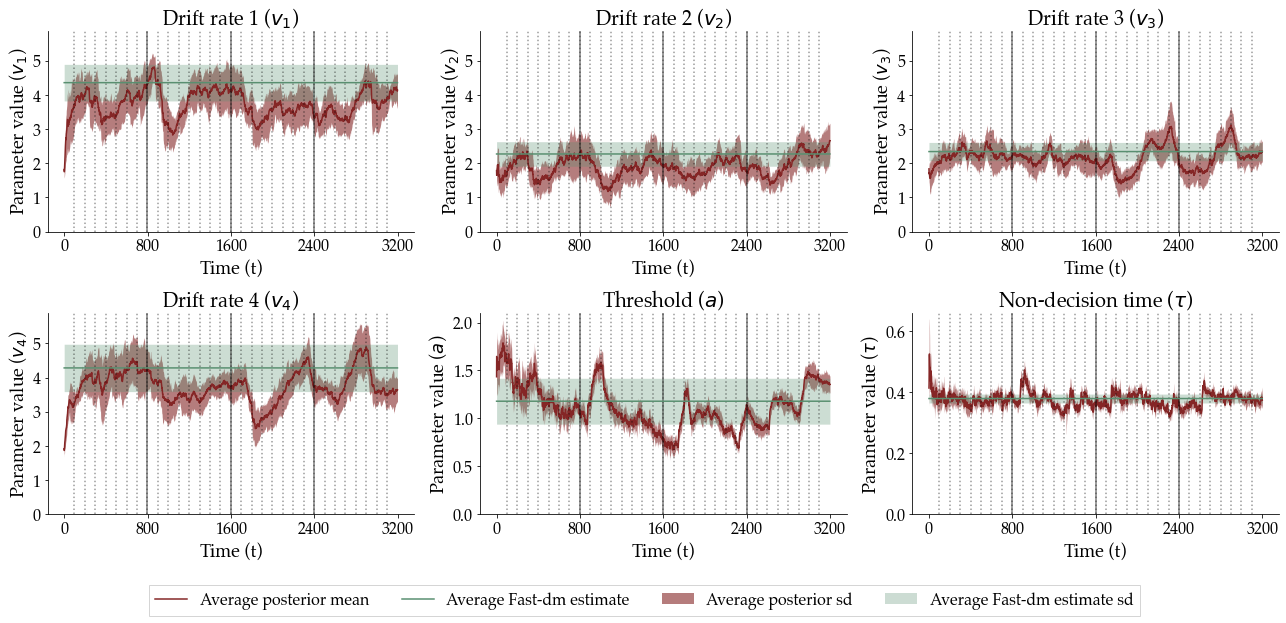

In [276]:
color_pred='#852626'   
means = np.array(post_d.mean()).mean(axis=0)
std = np.array(post_d.mean()).std(axis=0)

post_max = np.array(means).max(axis=0).max()
upper_y_ax = post_max + 1

sigma_factors = [1]
alphas = [0.6]
serif_font = "Computer Modern Roman"
serif_font = "Palatino"

time = np.arange(x_nn.shape[1])
f, axarr = plt.subplots(2, 3, figsize=(18, 8))
counter = 0
for i, ax in enumerate(axarr.flat):
    
    ax.plot(time, means[:, i], color=color_pred, label='Average posterior mean')
    for sigma_factor, alpha in zip(sigma_factors, alphas):
        ci_upper = means[:, i] + sigma_factor * std[:, i]
        ci_lower = means[:, i] - sigma_factor * std[:, i]
        ax.fill_between(time, ci_upper, ci_lower, color=color_pred, alpha=alpha, linewidth=0, label='Average posterior sd')
        
    sns.despine(ax=ax)
    ax.set_xlabel('Time (t)', fontsize=18)
    ax.set_ylabel('Parameter value ({})'.format(par_names[i]), fontsize=18)
    ax.set_title(par_labels[i] + ' ({})'.format(par_names[i]), fontsize=20)
    ax.set_xticks(np.arange(0, 3201, 800))
    ax.tick_params(axis='both', which='major', labelsize=16)
    if i < 4:
        ax.set_ylim(0, upper_y_ax)
    else:
        ax.set_ylim(0)
    ax.grid(False)

    # vertical bars
    for idx in np.arange(799, 2400, 800):
        if idx == 799:
            ax.axvline(idx, color='black', linestyle='solid', lw=1.5, alpha=0.5)
        else:
            ax.axvline(idx, color='black', linestyle='solid', lw=1.5, alpha=0.5)
    for idx in np.arange(99, 3100, 100):
        if idx == 99:
            ax.axvline(idx, color='black', linestyle='dotted', lw=1.5, alpha=0.4)
        else:
            ax.axvline(idx, color='black', linestyle='dotted', lw=1.5, alpha=0.4)


    # horizontal fast-dm params
    ax.plot(time, np.repeat(fast_dm_means[i], x_nn.shape[1]), color='#598f70', alpha=1, label='Average Fast-dm estimate')
    ax.fill_between(time, fast_dm_means[i] - fast_dm_sd[i], fast_dm_means[i] + fast_dm_sd[i], color='#598f70', alpha=0.3, linewidth=0, label='Average Fast-dm estimate sd')


    f.subplots_adjust(hspace=0.5)
    if i == 0:
        f.legend(fontsize=16, loc='center', 
                    bbox_to_anchor=(0.5, -0.05),fancybox=False, shadow=False, ncol=4)

f.tight_layout()
f.savefig("plots/average_param_dynamic_sub.png", dpi=300, bbox_inches="tight")

In [273]:
fast_dm_means - fast_dm_sd

array([3.82542566, 1.91262264, 2.07487737, 3.58935315, 0.93968647,
       0.36453491, 0.22867263, 0.07919443])